In [39]:
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command

import datetime
import config as cfg

llm = cfg.llm

#. State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    active_agent: str


In [36]:

class StoreChatInfo:
    def __init__(self):
        self.user_data = {
            "nome_completo": None,
            "numero_matricula": None,
            "unidade": None,
            "modo": None,
        }

        self.email_content = {
            'user_data': self.user_data,
            'pergunta': None,
            'resposta': None,
            'feedback': None,
            'data': datetime.datetime.now().strftime('%d/%m/%Y %H:%M')
        }   

    def store_user_data(self, info: dict):
        for key in self.user_data:
            if key in info and key is not None:
                self.user_data[key] = info[key]
    
    def build_email(self, email_body: dict):
        for key in self.email_content:
            if key in email_body and key is not None:
                self.email_content[key] = email_body[key]
    
    def get_info(self):
        return self.user_data
    
    def is_complete(self):
        return all(value is not None and value != "" for value in self.user_data.values())
    
stored_infos = StoreChatInfo()

#captura os dados pessoais do estudante
def storage_tool(
nome_completo:    str | None = None,
numero_matricula: str | int | None = None,
unidade:          str | None = None,
modo:             str | None = None,
):
    
    info = {
        'nome_completo': nome_completo,
        'numero_matricula': numero_matricula,
        'unidade' : unidade,
        'modo': modo
    }
    stored_infos.store_user_data(info = info)

    return info
storage_tool.__doc__ = cfg.Docstrings.storage_tool

#captura os dados da conversa
def register_chat_info(
pergunta: str | None = None,
resposta: str | None = None,
feedback: str | None = None,
):
    chat_data = {
        'pergunta': pergunta,
        'resposta': resposta,
        'feedback': feedback,
    }
    stored_infos.build_email(email_body = chat_data)
    
    return chat_data
register_chat_info.__doc__ = cfg.Docstrings.register_chat_info

In [ ]:
def pick_mode(State: State) -> Command[Literal["mode_1"]]:
    message = State['messages']

    response = llm.bind_tools(tools = [storage_tool]).invoke(message)
    {'messages': response}

    if stored_infos.user_data['modo']:
        if '1' in stored_infos.user_data['modo']:
            return Command(goto="corretor_de_ensaios", update={'active_agent': 'mode 1'})
        if '2' in stored_infos.user_data['modo']:
            return Command(goto="responder_duvidas", update={'active_agent': 'mode 2'})
        if '3' in stored_infos.user_data['modo']:
            return Command(goto="agente_plano_de_ensino", update={'active_agent': 'mode 3'})
    else:
        return Command(goto = State['active_agent'], update={"active_agent": 'data_collector'})
    

In [56]:
def data_collector(State: State):
    response = llm.bind_tools(tools = [storage_tool]).invoke(State['messages'])
    return {'messages': response}

def mode_1(State: State):
    response = llm.bind_tools(tools = [register_chat_info]).invoke(State['messages'])
    return {'messages': response}

In [61]:
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)
graph_builder.add_node('data_collector', pick_mode)
graph_builder.add_node('mode_1', mode_1)

graph_builder.add_edge(START, 'data_collector')

checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

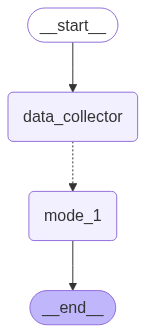

In [62]:
graph

In [63]:
from langchain_core.messages import SystemMessage, HumanMessage

def ApplicationLoop():

    while True:
        user_input = input("User: ")

        if user_input.lower() in ["quit", "exit", "q"]:
            print("[green3]Goodbye![/green3]")
            break

        prompt = {"messages": [
                SystemMessage(content = cfg.system_prompt, id = 'sys_prompt'),
                HumanMessage(content = user_input)
            ]}

        result = graph.invoke(prompt, config = {'configurable': {'thread_id': '1'}})
        last_message = result["messages"][-1]

        print(f"[bold green3]Assistant:[/] [grey78]{last_message.content}[/]")


In [64]:
ApplicationLoop()

ValueError: Arg info in docstring not found in function signature.